In [1]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values

import time

cudaq.set_target("nvidia")

In [2]:
# from qiskit_finance.applications.optimization import PortfolioOptimization
# from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_algorithms import QAOA
# from qiskit_algorithms.optimizers import COBYLA
# from qiskit.primitives import Sampler
# from qiskit_optimization.converters import QuadraticProgramToQubo
# from qiskit.circuit.library import QAOAAnsatz
# from qiskit_optimization.translators import to_ising
# from qiskit.result import marginal_distribution

In [3]:
# def po_normalize(B, P, ret, cov):
#     P_b = P / B
#     ret_b = ret * P_b
#     cov_b = np.diag(P_b) @ cov @ np.diag(P_b)
    
#     n_max = np.int32(np.floor(np.log2(B/P))) + 1
#     print("n_max:", n_max)
#     n_qs = np.cumsum(n_max)
#     n_qs = np.insert(n_qs, 0, 0)
#     n_qubit = n_qs[-1]
#     C = np.zeros((len(P), n_qubit))
#     for i in range(len(P)):
#          for j in range(n_max[i]):
#               C[i, n_qs[i] + j] = 2**j

#     P_bb = C.T @ P_b
#     ret_bb = C.T @ ret_b
#     print("ret_bb:", ret_bb)
#     cov_bb = C.T @ cov_b @ C
#     return P_bb, ret_bb, cov_bb, int(n_qubit)

# def ret_cov_to_QUBO(ret: np.ndarray, cov: np.ndarray, P: np.ndarray, lamb: float, q:float) -> np.ndarray:
#     di = np.diag(ret + lamb * (P*P + 2*P))
#     mat = 2 * lamb * np.outer(P, P) + q * cov
#     return di - mat

# def qubo_to_ising(qubo: np.ndarray, lamb: float) -> cudaq.SpinOperator:
#     spin_op = lamb
#     for i in range(qubo.shape[0]):
#         for j in range(qubo.shape[1]):
#                 if i != j:
#                     spin_op += qubo[i, j] * ((spin.i(i) - spin.z(i)) / 2 * (spin.i(j) - spin.z(j)) / 2)
#                 else:
#                     spin_op += qubo[i, j] * (spin.i(i) - spin.z(i)) / 2
#     return spin_op

# def process_ansatz_values(H: cudaq.SpinOperator) -> Tuple[List[int], List[float], List[int], List[int], List[float]]:
#     HH = H.get_raw_data()

#     idxs = [[j - len(HH[0][i])//2 for j in range(len(HH[0][i])) if HH[0][i][j]] for i in range(len(HH[0]))]

#     HH = [(idxs[i], HH[1][i], sum(HH[0][i])) for i in range(len(HH[0]))]
#     HH = sorted(HH, key=lambda x: (x[2], x[0]), reverse=False)

#     idx_1 = []
#     coeff_1 = []
#     idx_2_a, idx_2_b = [], []
#     coeff_2 = []
#     for i in range(len(HH)):
#         if HH[i][2] == 1:
#             idx_1.append(HH[i][0][0])
#             coeff_1.append(HH[i][1].real)
#         elif HH[i][2] == 2:
#             idx_2_a.append(HH[i][0][0])
#             idx_2_b.append(HH[i][0][1])
#             coeff_2.append(HH[i][1].real)
#     # print(HH)

#     return idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2

# HAMILTONIAN BY CUDAQ

### by random values

In [4]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 1 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)


[[1.59546774 0.96624519 1.0342813 ]
 [0.96624519 1.59509846 0.73717746]
 [1.0342813  0.73717746 1.98545026]]
n_max: [1 1 1]
ret_bb: [1.   1.25 1.5 ]
n_qubit: 3


In [5]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-1+0i) * I0 + (1+0i) * Z0 + (1+0i) + (1+0i) * I0I1 + (-1+0i) * I0Z1 + (-1+0i) * Z0I1 + (1+0i) * Z0Z1 + (1+0i) * I0I2 + (-1+0i) * I0Z2 + (-1+0i) * Z0I2 + (1+0i) * Z0Z2 + (-1.125+0i) * I1 + (1.125+0i) * Z1 + (1+0i) * I1I2 + (-1+0i) * I1Z2 + (-1+0i) * Z1I2 + (1+0i) * Z1Z2 + (-1.25+0i) * I2 + (1.25+0i) * Z2
[0, 0, 0, 1, 1, 1, 2, 2, 2]
[1.0, -1.0, -1.0, -1.0, 1.125, -1.0, -1.0, -1.0, 1.25]

[0, 0, 1]
[1, 2, 2]
[1.0, 1.0, 1.0]


### by stock values

In [122]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 1.5 # Budget Penalty
q = 0 # Volatility Weight
data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [123]:
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

n_max: [1 1 2]
ret_bb: [0.00077414 0.00056486 0.00034333 0.00068666]
n_qubit: 4


In [124]:
print(H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

(-0.692933+0i) * I0 + (0.692933+0i) * Z0 + (1.5+0i) + (0.736321+0i) * I0I1 + (-0.736321+0i) * I0Z1 + (-0.736321+0i) * Z0I1 + (0.736321+0i) * Z0Z1 + (0.52755+0i) * I0I2 + (-0.52755+0i) * I0Z2 + (-0.52755+0i) * Z0I2 + (0.52755+0i) * Z0Z2 + (1.0551+0i) * I0I3 + (-1.0551+0i) * I0Z3 + (-1.0551+0i) * Z0I3 + (1.0551+0i) * Z0Z3 + (-0.672877+0i) * I1 + (0.672877+0i) * Z1 + (0.495104+0i) * I1I2 + (-0.495104+0i) * I1Z2 + (-0.495104+0i) * Z1I2 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * I1I3 + (-0.990207+0i) * I1Z3 + (-0.990207+0i) * Z1I3 + (0.990207+0i) * Z1Z3 + (-0.552253+0i) * I2 + (0.552253+0i) * Z2 + (0.709452+0i) * I2I3 + (-0.709452+0i) * I2Z3 + (-0.709452+0i) * Z2I3 + (0.709452+0i) * Z2Z3 + (-0.74978+0i) * I3 + (0.74978+0i) * Z3
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[0.692932625294636, -0.7363205742864409, -0.5275504559031046, -1.0551009118062091, -0.7363205742864409, 0.6728767872082475, -0.4951036592183681, -0.9902073184367362, -0.5275504559031046, -0.4951036592183681, 0.5522530522

# QISKIT QAOA

In [125]:
# # cov[0, 2] = cov[2, 0] = 1
# print(cov)
# portfolio_qis = PortfolioOptimization(
#     expected_returns=ret,
#     covariances=cov,
#     risk_factor=0,
#     budget=1,
#     bounds=[(0, 1), (0, 1), (0, 1)]
# )
# qp = portfolio_qis.to_quadratic_program()
# converter = QuadraticProgramToQubo()
# qubo = converter.convert(qp)
# op, offset = to_ising(qubo)

In [126]:
# opp = op.to_sparse_list()
# print(opp)
# idx_1_qis = []
# coeff_1_qis = []
# idx_2_a_qis, idx_2_b_qis = [], []
# coeff_2_qis = []

# for i in range(len(opp)):
#     if len(opp[i][1]) == 1:
#         idx_1_qis.append(opp[i][1][0])
#         coeff_1_qis.append(opp[i][2].real)
#     elif len(opp[i][1]) == 2:
#         idx_2_a_qis.append(opp[i][1][0])
#         idx_2_b_qis.append(opp[i][1][1])
#         coeff_2_qis.append(opp[i][2].real)

# print(idx_1_qis)
# print(coeff_1_qis, end="\n\n")
# print(idx_2_a_qis)
# print(idx_2_b_qis)
# print(coeff_2_qis)

In [127]:
# qaoa_ansatz = QAOAAnsatz(op, reps=2)
# decomposed = qaoa_ansatz.decompose(reps=2)
# decomposed.draw(output='text')

In [128]:
# qaoa = QAOA(
#     optimizer=COBYLA(maxiter=1000),
#     reps=2,
#     sampler=Sampler()
# )

# meo = MinimumEigenOptimizer(qaoa)

# # result = meo.solve(qubo)

In [129]:
# qaoa_result = qaoa.compute_minimum_eigenvalue(operator=op)
# print("Optimized parameters:", qaoa_result.optimal_point)

In [130]:
# counts = qaoa_result.eigenstate
# counts = np.array(list(counts.values()))

In [131]:
# plt.figure(figsize=(10, 5))
# # plt.bar(range(2**qubit_count), list(result.values()))
# plt.bar(range(2**op.num_qubits), counts)
# # plt.xlabel('Cut')
# plt.ylabel('Frequency')
# plt.title('Distribution')
# # plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.show()

# CUDA QAOA

In [132]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [133]:
# print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

In [134]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float]):
    qreg = cudaq.qvector(qubit_count)
    # qreg = cudaq.qvector(3)
    h(qreg)

    for i in range(layer_count):
        # for idxs, coeff, l in sorted_raw_ham:
        #     if l == 1:
        #         rz(2 * coeff * thetas[i], qreg[idxs[0]])
        #     elif l == 2:
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        #         rz(2 * coeff * thetas[i], qreg[idxs[1]])
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        # for i in range(qubit_count):
        #     rx(2.0 * thetas[layer_count + i], qreg[i])

        for j in range(len(idx_1)):
            rz(2 * coeff_1[j] * thetas[i], qreg[idx_1[j]])
        
        for j in range(len(idx_2_a)):
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])
            rz(2 * coeff_2[j] * thetas[i], qreg[idx_2_b[j]])
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])

        for j in range(qubit_count):
            rx(2.0 * thetas[layer_count + i], qreg[j])

In [135]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [136]:
print(H)

(-0.692933+0i) * I0 + (0.692933+0i) * Z0 + (1.5+0i) + (0.736321+0i) * I0I1 + (-0.736321+0i) * I0Z1 + (-0.736321+0i) * Z0I1 + (0.736321+0i) * Z0Z1 + (0.52755+0i) * I0I2 + (-0.52755+0i) * I0Z2 + (-0.52755+0i) * Z0I2 + (0.52755+0i) * Z0Z2 + (1.0551+0i) * I0I3 + (-1.0551+0i) * I0Z3 + (-1.0551+0i) * Z0I3 + (1.0551+0i) * Z0Z3 + (-0.672877+0i) * I1 + (0.672877+0i) * Z1 + (0.495104+0i) * I1I2 + (-0.495104+0i) * I1Z2 + (-0.495104+0i) * Z1I2 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * I1I3 + (-0.990207+0i) * I1Z3 + (-0.990207+0i) * Z1I3 + (0.990207+0i) * Z1Z3 + (-0.552253+0i) * I2 + (0.552253+0i) * Z2 + (0.709452+0i) * I2I3 + (-0.709452+0i) * I2Z3 + (-0.709452+0i) * Z2I3 + (0.709452+0i) * Z2Z3 + (-0.74978+0i) * I3 + (0.74978+0i) * Z3


In [137]:
print(cudaq.draw(kernel_qaoa_ham, n_qubit, 1, [0.5]*4, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)) 

     ╭───╮╭────────────╮ ╭─────────────╮╭─────────────╮╭────────────╮      »
q0 : ┤ h ├┤ rz(0.6929) ├─┤ rz(-0.7363) ├┤ rz(-0.5276) ├┤ rz(-1.055) ├───●──»
     ├───┤├────────────┴╮├────────────┬╯├─────────────┤├────────────┴╮╭─┴─╮»
q1 : ┤ h ├┤ rz(-0.7363) ├┤ rz(0.6729) ├─┤ rz(-0.4951) ├┤ rz(-0.9902) ├┤ x ├»
     ├───┤├─────────────┤├────────────┴╮├────────────┬╯├─────────────┤╰───╯»
q2 : ┤ h ├┤ rz(-0.5276) ├┤ rz(-0.4951) ├┤ rz(0.5523) ├─┤ rz(-0.7095) ├─────»
     ├───┤├────────────┬╯├─────────────┤├────────────┴╮├────────────┬╯     »
q3 : ┤ h ├┤ rz(-1.055) ├─┤ rz(-0.9902) ├┤ rz(-0.7095) ├┤ rz(0.7498) ├──────»
     ╰───╯╰────────────╯ ╰─────────────╯╰─────────────╯╰────────────╯      »

################################################################################

                                                                  ╭───────╮»
────────────────●────●──────────────────●────●─────────────────●──┤ rx(1) ├»
╭────────────╮╭─┴─╮  │                  │    │                 │  ╰───

# Ansatz Architecture

In [138]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.max_iterations = 1000

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [-0.1021561085316176, 0.2474410649376172, -0.1340129050305478, 0.257167964657551, 0.037126978617188944, -0.3735615622289741, -0.01099372946576016, -0.3069556175279715, 0.17678568368968384, 0.11139319196712327]


# Optimize

In [139]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_ham, H, n_qubit, layer_count, parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [140]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO"):
    os.makedirs("./output_PO")
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = 0.49871018126739897
optimal_parameters = [0.11531998522278528, 0.31827551054093406, -0.030649822497172984, 0.3515796951340401, 0.20660246693287987, -0.5096361505664914, 0.003952813131705068, -0.2495321783145116, -0.013371677600434253, -0.1360952328514953]
Time taken =  1.6430790424346924


In [141]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
0010 212572 0.212572
|q0>|q1>|q2>...


In [146]:
state = cudaq.get_state(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
print(state)

for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    print(bb, abs(state[i])**2)

print(len(state))

SV: [(0.345327,-0.225099), (0.332339,-0.279627), (0.337298,-0.280719), (-0.0144693,-0.0493054), (0.358987,-0.288024), (0.0493901,-0.131572), (0.0654864,-0.142354), (0.0387469,0.0245128), (0.280971,-0.305945), (0.0125349,0.0851821), (-0.00375852,0.0683176), (-0.0079563,0.0136694), (-0.0172825,-0.0419594), (0.0139265,-0.00945264), (0.0229557,-0.00941785), (0.00775037,-0.00891986)]

0000 0.16992055750937252
0001 0.17254724373516694
0010 0.21182977698174899
0011 0.0020592794232364847
0100 0.1925728003871763
0101 0.004681414762295907
0110 0.024553244638526876
0111 0.0006156593886313027
1000 0.1886405819741066
1001 0.007413116997823301
1010 0.019750499322745363
1011 0.0002833006049703813
1100 0.0026403815859183184
1101 0.0002501547957606629
1110 0.002102201792957073
1111 0.00013963225772737917
16


In [143]:
assert False

AssertionError: 

In [144]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

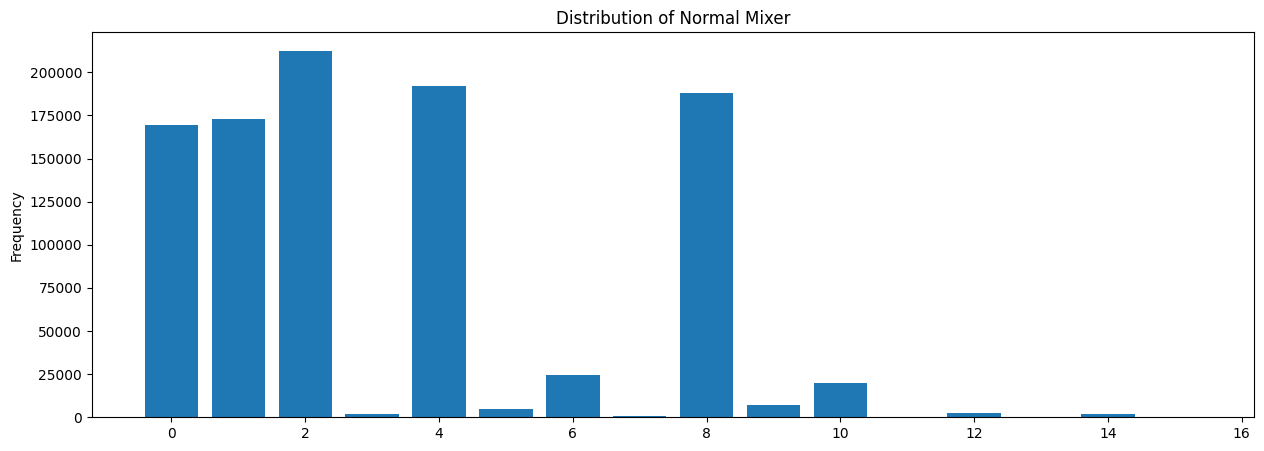

In [145]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Normal Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


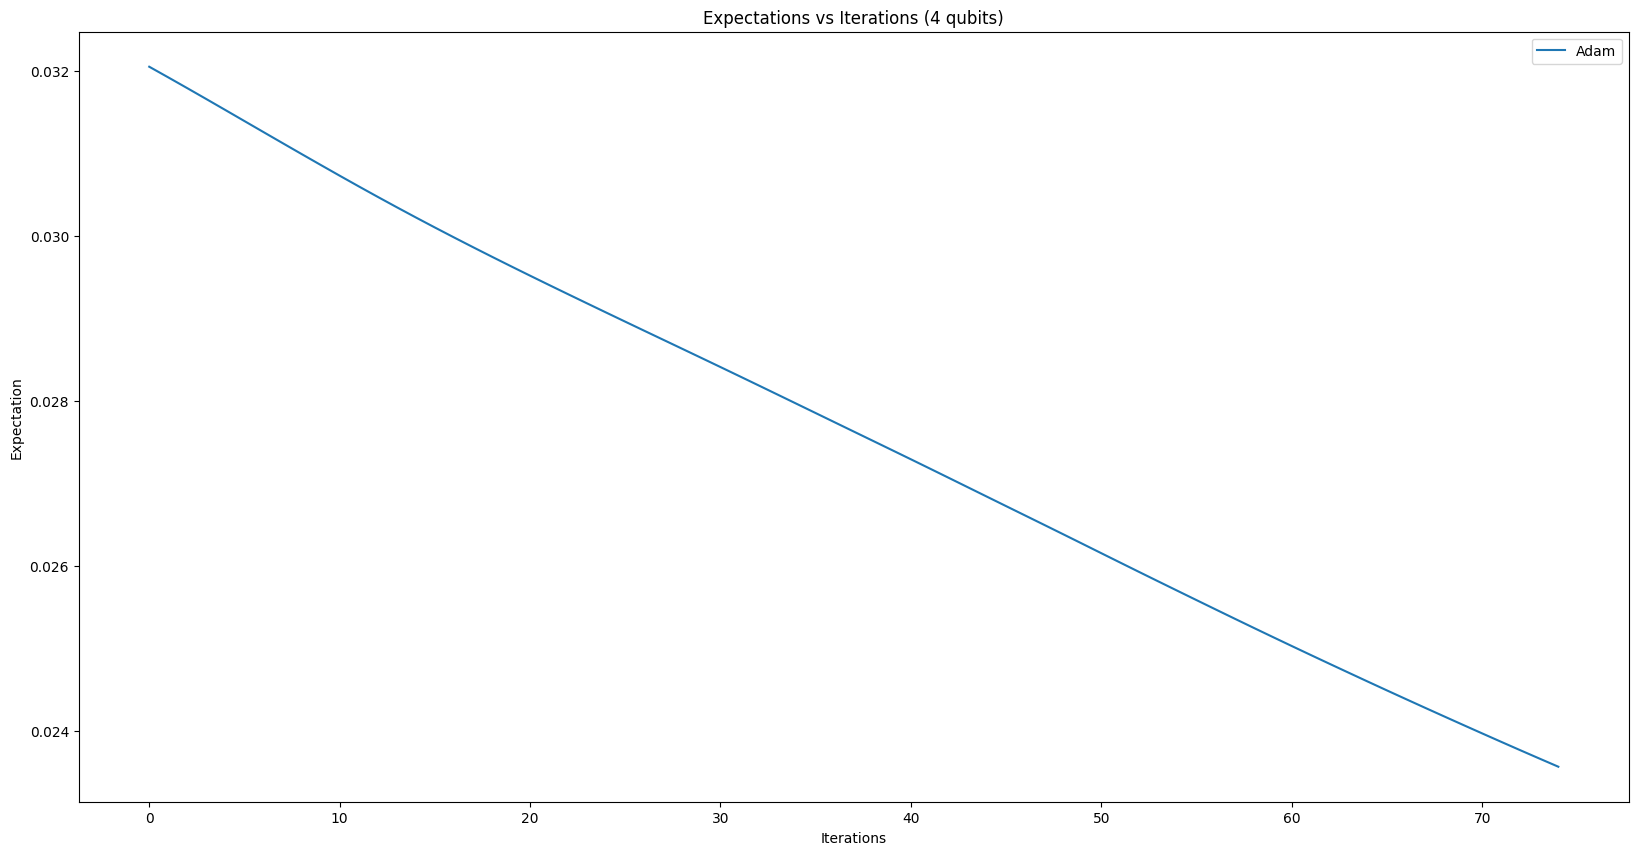

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()